# Look at UMAP outliers identified on the co-occ UMAP in more detail

In [1]:
from campa.constants import campa_config
from campa_ana.constants import SOURCE_DIR
from pathlib import Path
from campa.data import MPPData
from campa.tl import Experiment
from campa.tl import Cluster, FeatureExtractor
from campa.tl._cluster import add_clustering_to_adata
from campa.pl import annotate_img
from campa.utils import init_logging
import os
import numpy as np
import scanpy as sc
import seaborn as sns
import pandas as pd
import anndata as ad
import squidpy as sq
from sklearn.metrics import silhouette_score
import json
import matplotlib.pyplot as plt
import pickle
import matplotlib as mpl
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'
init_logging()

In [2]:
fig_dir = Path(SOURCE_DIR)/'figures'/'fig4'
# load adata
adata = ad.read(fig_dir/'cell_adata.h5ad')

# load corresponding experiment
exp = Experiment.from_dir('VAE_all/CondVAE_pert-CC')
data_dirs = exp.data_params['data_dirs']
annotation = exp.get_cluster_annotation(cluster_name='clustering_res0.5')

INFO:Experiment:Setting up experiment VAE_all/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in VAE_all/CondVAE_pert-CC
INFO:Experiment:Cluster annotation: using cluster data in aggregated/sub-0.001


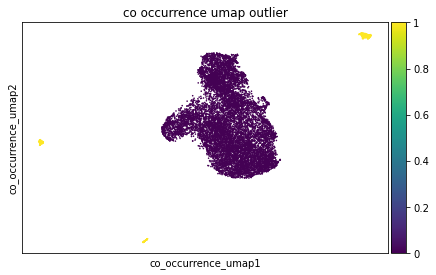

In [3]:
sc.pl.scatter(adata, basis='co_occurrence_umap', color=['co_occurrence_umap_outlier'])

outliers = adata[adata.obs['co_occurrence_umap_outlier']]

In [9]:
for well_name, g in outliers.obs.groupby('well_name'):
    print(well_name)
    print(g)

I09
      mapobject_id plate_name well_name  well_pos_y  well_pos_x  tpoint  \
11-0        199656    plate01       I09           5           2       0   
20-0        200755    plate01       I09           4           3       0   
74-0        228084    plate01       I09           0           1       0   
111-0       248093    plate01       I09           5           4       0   
118-0       256547    plate01       I09           2           3       0   
157-0       259775    plate01       I09           3           3       0   
167-0       259788    plate01       I09           3           3       0   
252-0       281060    plate01       I09           5           3       0   
276-0       291044    plate01       I09           0           3       0   
290-0       291064    plate01       I09           0           3       0   
318-0       324160    plate01       I09           0           2       0   
374-0       345899    plate01       I09           1           4       0   
431-0       359180   

INFO:MPPData:Setting mpp to empty array
INFO:MPPData:Created new: MPPData for NascentRNA (12132995 mpps with shape (1, 1, 35) from 886 objects). Data keys: ['x', 'y', 'obj_ids', 'mpp'].
INFO:MPPData:Loaded data from 184A1_unperturbed/I09.
INFO:MPPData:Setting mpp to empty array
INFO:MPPData:Created new: MPPData for NascentRNA (7218204 mpps with shape (1, 1, 34) from 557 objects). Data keys: ['y', 'x', 'obj_ids', 'clustering_res0.5', 'mpp'].
INFO:MPPData:Before subsetting: 886 objects
INFO:MPPData:Subsetting to 557 objects
INFO:MPPData:Updated data to keys ['x', 'y', 'obj_ids', 'mpp', 'clustering_res0.5']
INFO:MPPData:Loaded data from 184A1_unperturbed/I09, with base data from 184A1_unperturbed/I09
INFO:MPPData:Before subsetting: 557 objects
INFO:MPPData:Subsetting to 16 objects
INFO:MPPData:Setting mpp to empty array
INFO:MPPData:Created new: MPPData for NascentRNA (14097457 mpps with shape (1, 1, 35) from 1025 objects). Data keys: ['x', 'y', 'obj_ids', 'mpp'].
INFO:MPPData:Loaded data

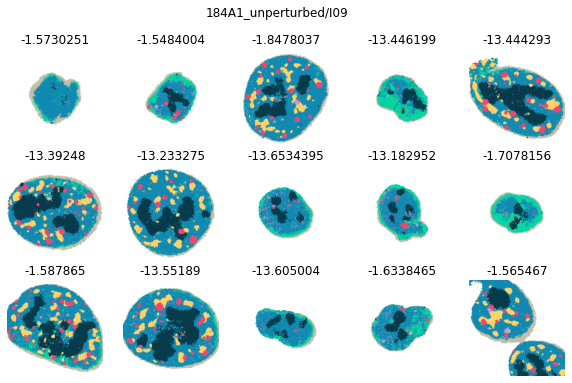

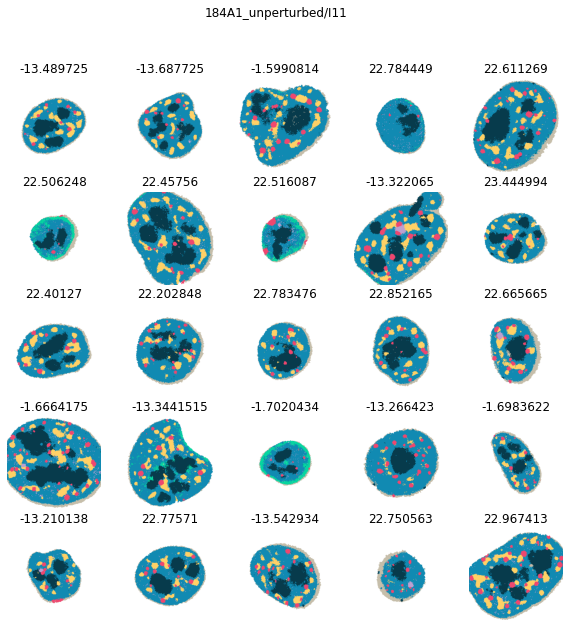

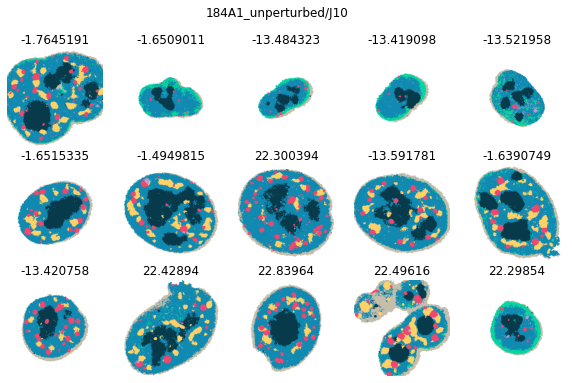

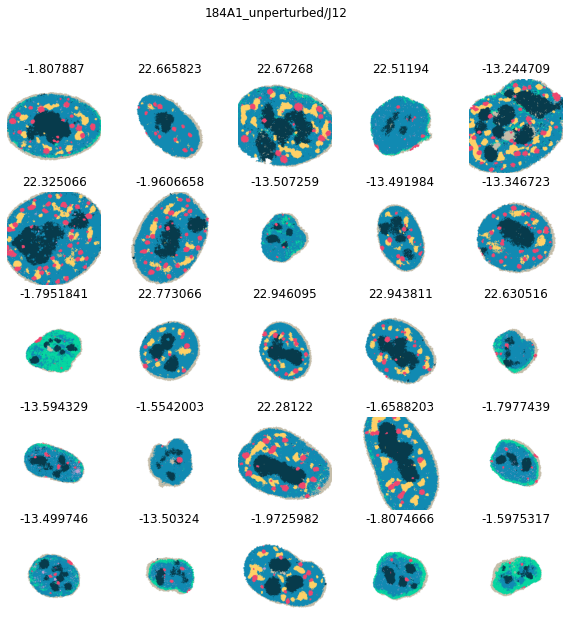

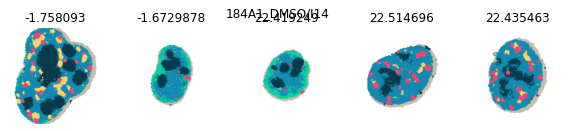

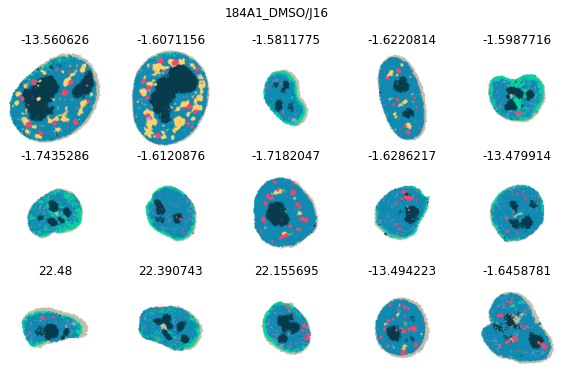

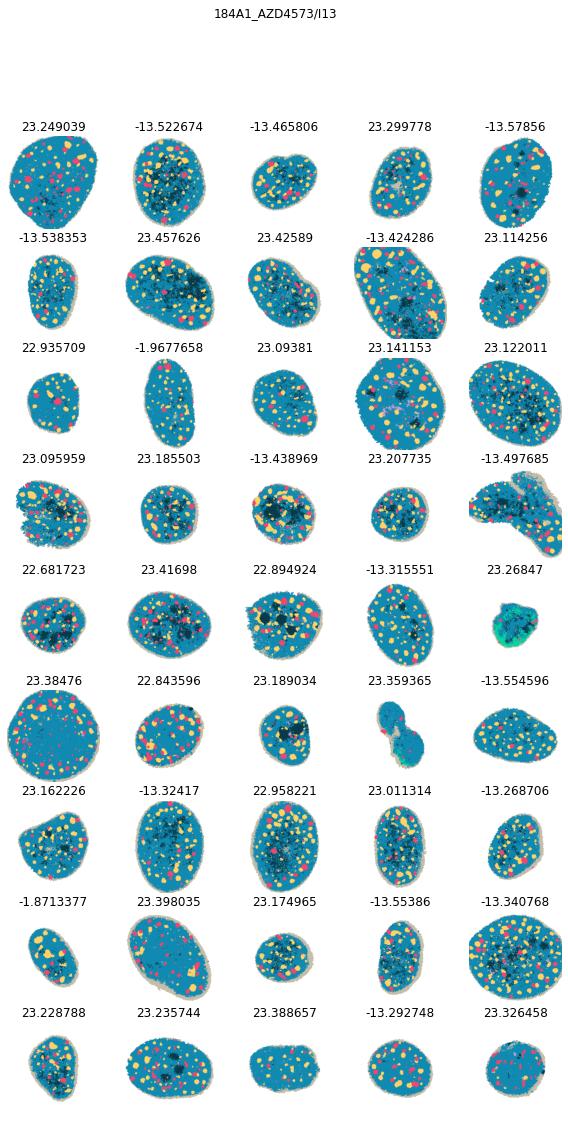

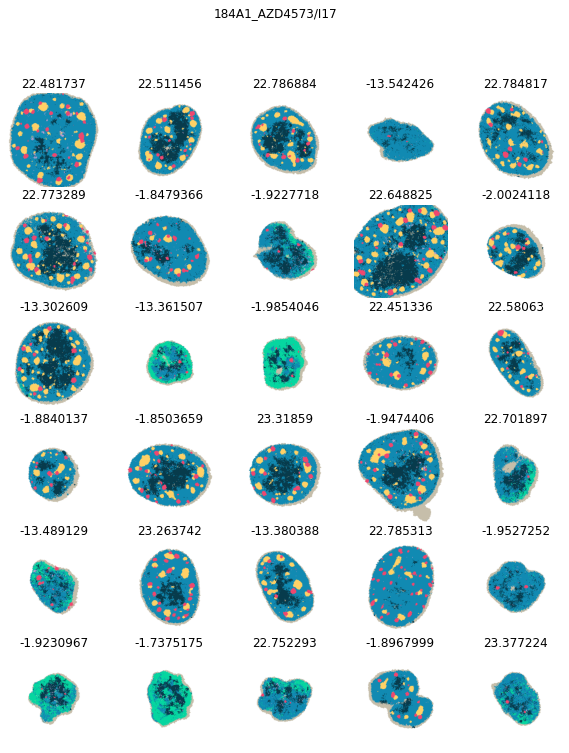

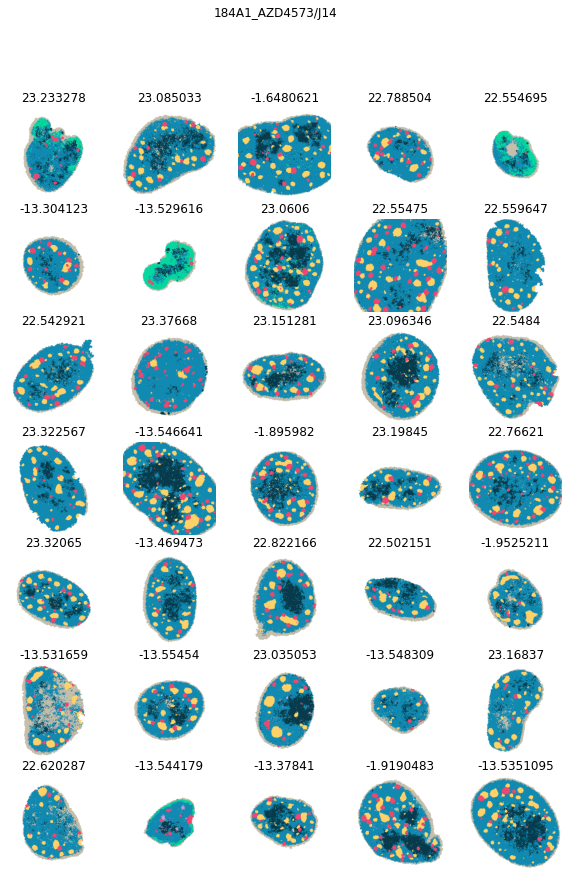

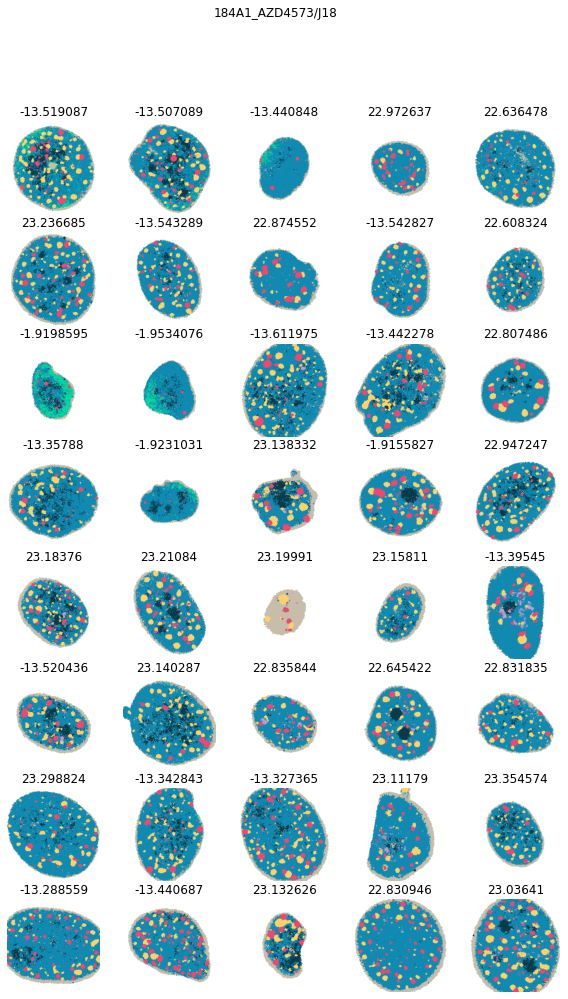

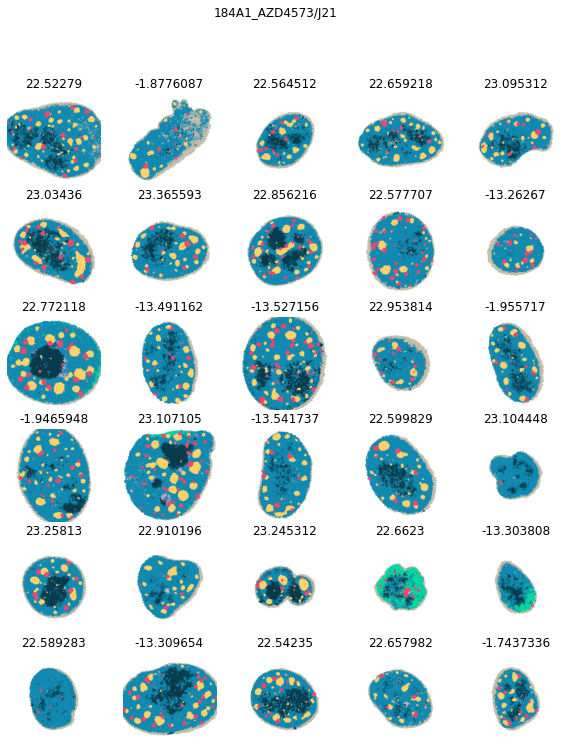

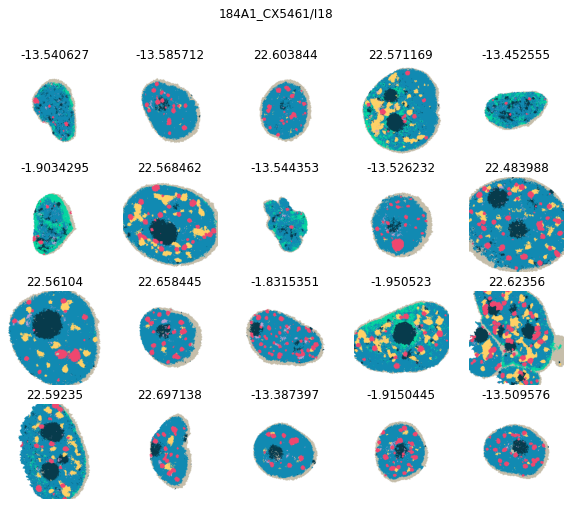

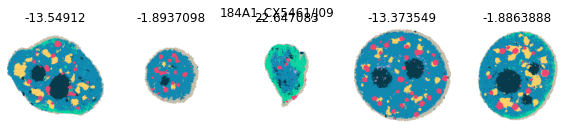

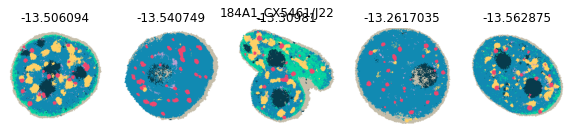

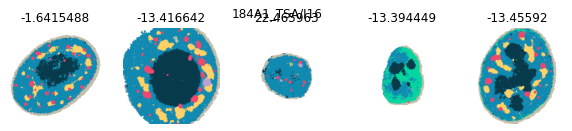

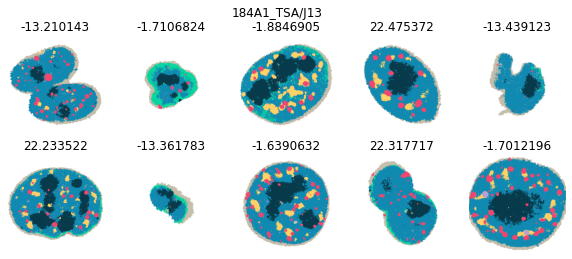

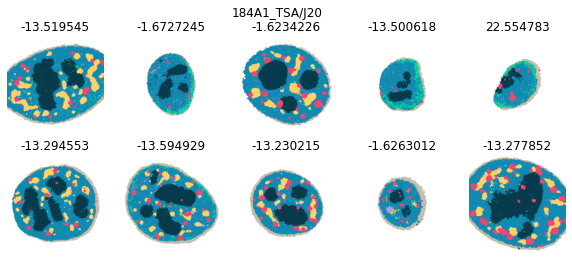

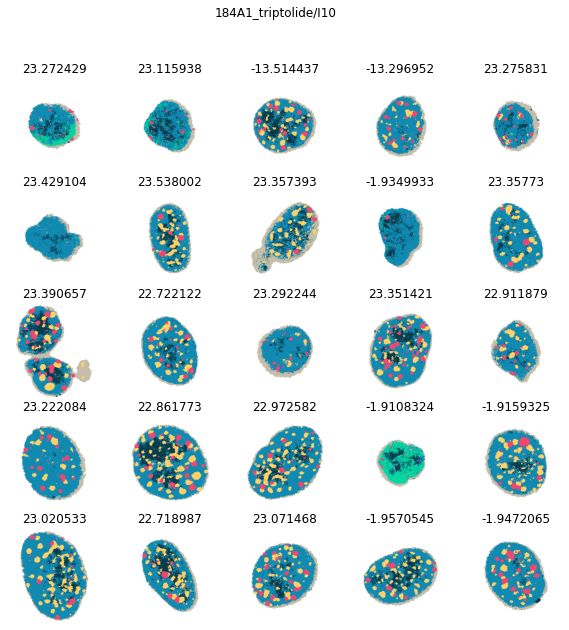

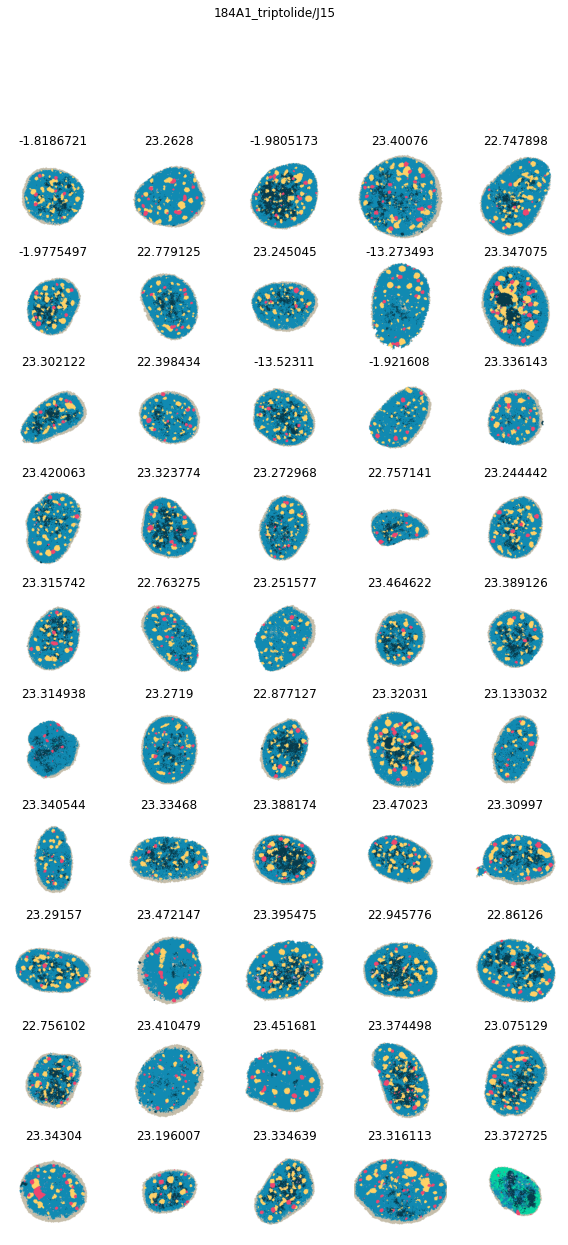

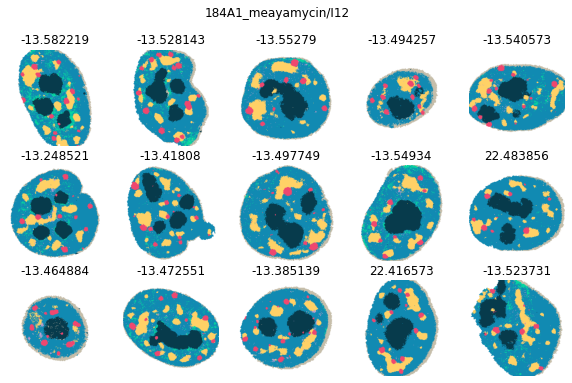

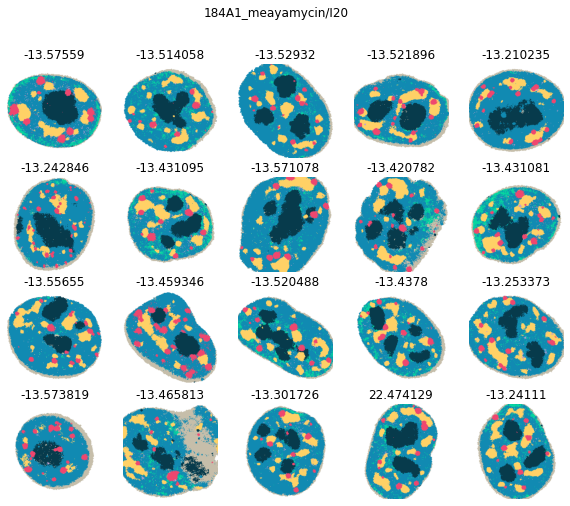

In [15]:
# load and plot outlier cells per well

for data_dir in data_dirs:
    res = outliers.obs[outliers.obs['well_name'] == data_dir.split('/')[-1]]

    if len(res) > 0:
        mpp_data = MPPData.from_data_dir(data_dir, base_dir=os.path.join(campa_config.EXPERIMENT_DIR, 'VAE_all/CondVAE_pert-CC/aggregated/full_data'), 
                                                        keys=['x', 'y', 'obj_ids', 'clustering_res0.5'], optional_keys=[])
        mpp_data.subset(obj_ids=[int(obj_id) for obj_id in list(res['mapobject_id'])])
        # convert clustering to str for correct color mapping (for this experiment are saved as int, but need to be converted to str)
        mpp_data._data['clustering_res0.5'] = mpp_data.data('clustering_res0.5').astype('<U21')
        imgs = mpp_data.get_object_imgs(data='clustering_res0.5', annotation_kwargs={'color':True, 'annotation': annotation, 'to_col': 'annotation'}, img_size=200)
        
        fig, axes = plt.subplots(len(imgs)//5, 5, figsize=(10, (len(imgs)//5)*2))
        for i,(img, ax) in enumerate(zip(imgs, axes.flat)):
            ax.imshow(img)
            obj_id = res['mapobject_id'][i]
            xcoord = outliers[outliers.obs['mapobject_id']==obj_id].obsm['X_co_occurrence_umap'][0,0]
            ax.set_title(xcoord)
        for ax in axes.flat:
            ax.axis('off')
        fig.suptitle(data_dir)


In [17]:
exp = Experiment.from_dir('VAE_all/CondVAE_pert-CC')
extrs = {data_dir: FeatureExtractor.from_adata(os.path.join(exp.full_path, 'aggregated/full_data', data_dir, 'features_annotation.h5ad')) 
    for data_dir in exp.data_params['data_dirs']}

# get combined adata
adata = ad.concat([extr.adata for extr in extrs.values()], index_unique='-', uns_merge='same')

INFO:Experiment:Setting up experiment VAE_all/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in VAE_all/CondVAE_pert-CC
INFO:Experiment:Setting up experiment VAE_all/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in VAE_all/CondVAE_pert-CC
INFO:Experiment:Cluster annotation: using cluster data in aggregated/sub-0.001
INFO:Experiment:Setting up experiment VAE_all/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in VAE_all/CondVAE_pert-CC
INFO:Experiment:Cluster annotation: using cluster data in aggregated/sub-0.001
INFO:Experiment:Setting up experiment VAE_all/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in VAE_all/CondVAE_pert-CC
INFO:Experiment:Cluster annotation: using cluster data in aggregated/sub-0.001
INFO:Experiment:Setting up experiment VAE_all/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in VAE_all/CondVAE_pert-CC
INFO:Experiment:Cluster annotation: using cluster dat

In [35]:
# from plots above, reason for outlier clusters could be missing objects

# look at size - load adata from extrs again, because have added size
adata_outliers = adata[adata.obs['mapobject_id'].isin(outliers.obs['mapobject_id'])]
assert (outliers.obs['mapobject_id'] == adata_outliers.obs['mapobject_id']).all()
adata_outliers.obsm['X_co_occurrence_umap'] = outliers.obsm['X_co_occurrence_umap']

In [45]:
# differentiate outliers in 3 original groups
group1 = adata_outliers.obsm['X_co_occurrence_umap'][:,0]<-4
group2 = (adata_outliers.obsm['X_co_occurrence_umap'][:,0]<0) & ~group1
group3 = ~group1 & ~group2

<AxesSubplot:>

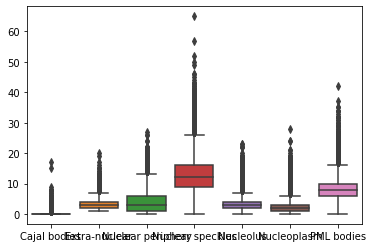

In [48]:
sns.boxplot(data=adata.obsm['object_count'])

<AxesSubplot:>

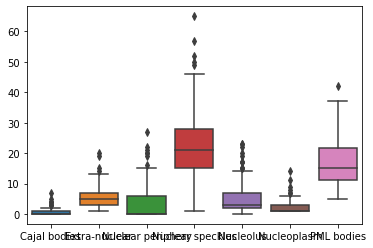

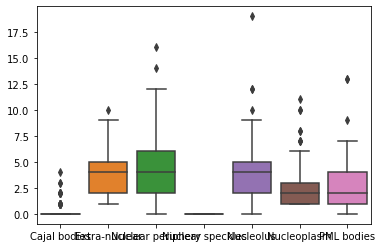

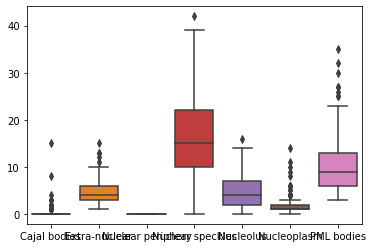

In [46]:
sns.boxplot(data=adata_outliers[group1].obsm['object_count'])
plt.figure()
sns.boxplot(data=adata_outliers[group2].obsm['object_count'])
plt.figure()
sns.boxplot(data=adata_outliers[group3].obsm['object_count'])

In [24]:
# group 2 has no nuclear speckles
# group 3 had no nuclear periphery

Cajal bodies  Extra-nuclear  Nuclear periphery  Nuclear speckles  \
11-0            36.0      50.888889         126.181818               NaN   
20-0             NaN     232.500000         188.400000               NaN   
74-0             NaN     614.666667          92.666667               NaN   
111-0            NaN     277.666667         220.500000        168.700000   
118-0            NaN     776.000000          84.857143         99.800000   
...              ...            ...                ...               ...   
291-20           NaN    1295.000000          74.750000        438.125000   
345-20           NaN     903.000000                NaN        139.000000   
432-20           NaN     121.000000         135.545455        378.777778   
433-20           NaN    1711.000000          36.150000        198.125000   
436-20           NaN     565.500000          28.714286        215.333333   

          Nucleolus   Nucleoplasm  PML bodies  
11-0     713.500000   1609.333333   45.500000  
20-0     238.600000   1497.000000   28.000000  
74-0      25.666667   5575.000000         NaN  
111-0   5707.000000   5838.500000   90.000000  
118-0   1780.666667  11080.000000   61.272727  
...             ...           ...         ...  
291-20  2097.000000  12623.000000  105.615385  
345-20  2308.000000  12713.000000  120.285714  
432-20  4130.000000   5712.500000  234.750000  
433-20  3634.000000  14231.000000   94.125000  
436-20  1510.333333  18344.000000   94.900000  

[484 rows x 7 columns]

<AxesSubplot:>

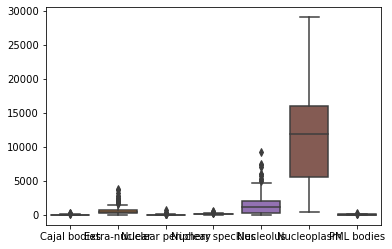

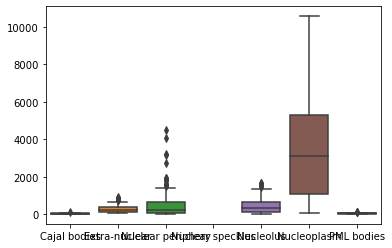

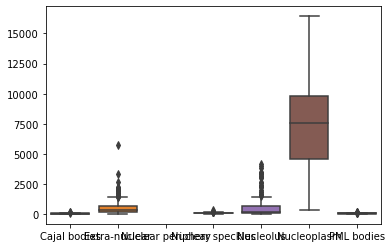

In [49]:
sns.boxplot(data=adata_outliers[group1].obsm['object_size_mean'])
plt.figure()
sns.boxplot(data=adata_outliers[group2].obsm['object_size_mean'])
plt.figure()
sns.boxplot(data=adata_outliers[group3].obsm['object_size_mean'])

In [7]:
imgs = mpp_data.get_object_imgs(data='clustering_res0.5')

In [15]:
clustering_old = mpp_data.data('clustering_res0.5').copy()

In [16]:
clustering_old

array([4, 4, 4, ..., 4, 4, 4])

In [17]:
cluster_data_dir = os.path.join('VAE_all/CondVAE_pert-CC', 'aggregated/sub-0.001')

cluster_name = 'clustering_res0.5'

cl = Cluster.from_cluster_data_dir(cluster_data_dir)
cl.set_cluster_name(cluster_name)

cl.project_clustering(mpp_data)

INFO:MPPData:Created new: MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['x', 'y', 'obj_ids', 'mpp', 'latent', 'umap'].
INFO:MPPData:Loaded data from VAE_all/CondVAE_pert-CC/aggregated/sub-0.001.
INFO:Cluster:Loaded cluster_mpp MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['x', 'y', 'obj_ids', 'mpp', 'latent', 'umap'].
INFO:Cluster:cannot create annotation without clustering in cluster_mpp
INFO:MPPData:Created new: MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['x', 'y', 'obj_ids', 'mpp', 'latent', 'clustering_res0.5', 'umap'].
INFO:MPPData:Loaded data from VAE_all/CondVAE_pert-CC/aggregated/sub-0.001.
INFO:Cluster:Loaded cluster_mpp MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['x', 'y', 'obj_ids', 'mpp', 'latent', 'clustering_res0.5', 'umap'].
INFO:Cluster:Projecting clustering to 274795 samples
INFO:Cluster:

In [23]:
mpp_data.data('clustering_res0.5')

array(['4', '4', '4', ..., '4', '4', '4'], dtype='<U21')

In [21]:
imgs = mpp_data_new.get_object_imgs(data='clustering_res0.5', annotation_kwargs={'color':True, 'annotation': annotation, 'to_col': 'annotation'}, img_size=160)


annotate_img: converting img to str before annotating
annotate_img: converting img to str before annotating
annotate_img: converting img to str before annotating
annotate_img: converting img to str before annotating
annotate_img: converting img to str before annotating
annotate_img: converting img to str before annotating
annotate_img: converting img to str before annotating
annotate_img: converting img to str before annotating
annotate_img: converting img to str before annotating
annotate_img: converting img to str before annotating
annotate_img: converting img to str before annotating
annotate_img: converting img to str before annotating
annotate_img: converting img to str before annotating
annotate_img: converting img to str before annotating
annotate_img: converting img to str before annotating
annotate_img: converting img to str before annotating


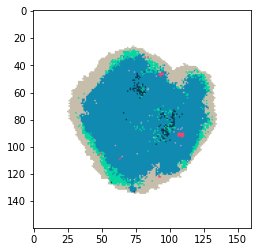

In [7]:
plt.imshow(imgs[0])

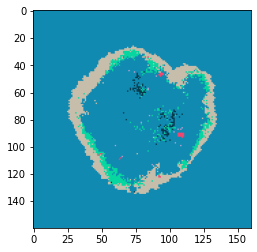

In [6]:
plt.imshaaaaaow(imgs[0])

In [7]:
import campa.data._data

In [11]:
campa.data._data.annotate_img??

Signature:
campa.data._data.annotate_img(
    img,
    annotation=None,
    from_col='clustering',
    to_col=None,
    color=False,
)
Source:   
def annotate_img(img, annotation=None, from_col='clustering', to_col=None, color=False):
    """
    Args:
        img: image to annotate
        annotation: pd.DataFrame containing annotation (from Cluster)
        from_col: column containing current values in image
        to_col: column containing desired mapping. If None, use from_col.
        color: if True, use column to_col+"_colors" to get colormap and color image
    """
    if to_col is None:
        to_col = from_col
    if color:
        to_col = to_col + '_colors'
        res = np.zeros(img.shape + (3,), dtype=np.uint8)
    else:
        if from_col == to_col:
            # no need to change anything
            return img
        res = np.zeros_like(img, dtype=annotation[to_col].dtype)
        # ensure that img has the correct dtype, we expect strings
        if img.dtype != 'st

In [6]:
imgs[0]

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [9]:
imgs = mpp_data.get_object_imgs(data='clustering_res0.5')

In [68]:
list(annotation['clustering_res0.5'])

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '']

In [10]:
np.unique(imgs[0]).dtype == 'int64'

True

In [12]:
for _,row in annotation.iterrows():
    to_value = row['annotation_colors']
    print(to_value)
    print(row['clustering_res0.5'])
    if imgs[0].dtype != 'str':
        print('annotate_img: converting img to str before annotating')
        imgs[0] = imgs[0].astype('str')
    print(np.where(imgs[0] == row['clustering_res0.5']))

#118ab2
0
annotate_img: converting img to str before annotating
(array([  0,   0,   0, ..., 108, 108, 108]), array([  0,   1,   2, ..., 107, 108, 109]), array([0, 0, 0, ..., 0, 0, 0]))
#073b4c
1
annotate_img: converting img to str before annotating
(array([ 19,  20,  21,  22,  22,  23,  23,  23,  24,  25,  25,  27,  27,
        28,  28,  29,  29,  29,  30,  30,  30,  30,  31,  31,  31,  31,
        31,  31,  32,  32,  32,  32,  32,  32,  33,  33,  33,  33,  33,
        33,  33,  34,  34,  34,  34,  34,  35,  35,  35,  36,  36,  38,
        46,  47,  48,  48,  49,  49,  49,  50,  50,  50,  50,  50,  50,
        50,  51,  51,  51,  52,  52,  52,  52,  52,  53,  53,  53,  53,
        54,  54,  54,  55,  56,  56,  56,  57,  58,  58,  58,  58,  58,
        59,  59,  59,  59,  59,  59,  60,  61,  61,  61,  61,  62,  62,
        62,  62,  63,  63,  63,  64,  64,  64,  65,  65,  65,  65,  66,
        66,  66,  67,  68,  68,  69,  69,  70,  72, 100, 107]), array([56, 51, 51, 51, 52, 50, 51, 53,

In [14]:
from campa.pl import annotate_img

annotate_img(imgs[0], annotation=annotation, from_col='clustering_res0.5', to_col='annotation', color=True)

array([[[ 17, 138, 178],
        [ 17, 138, 178],
        [ 17, 138, 178],
        ...,
        [ 17, 138, 178],
        [ 17, 138, 178],
        [ 17, 138, 178]],

       [[ 17, 138, 178],
        [ 17, 138, 178],
        [ 17, 138, 178],
        ...,
        [ 17, 138, 178],
        [ 17, 138, 178],
        [ 17, 138, 178]],

       [[ 17, 138, 178],
        [ 17, 138, 178],
        [ 17, 138, 178],
        ...,
        [ 17, 138, 178],
        [ 17, 138, 178],
        [ 17, 138, 178]],

       ...,

       [[ 17, 138, 178],
        [ 17, 138, 178],
        [ 17, 138, 178],
        ...,
        [ 17, 138, 178],
        [ 17, 138, 178],
        [ 17, 138, 178]],

       [[ 17, 138, 178],
        [ 17, 138, 178],
        [ 17, 138, 178],
        ...,
        [ 17, 138, 178],
        [ 17, 138, 178],
        [ 17, 138, 178]],

       [[ 17, 138, 178],
        [ 17, 138, 178],
        [ 17, 138, 178],
        ...,
        [ 17, 138, 178],
        [ 17, 138, 178],
        [ 17, 138, 178]]

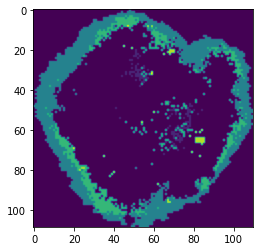

In [52]:
plt.imshow(imgs[0][:,:,0])

In [45]:
np.unique(mpp_data.data('clustering_res0.5'))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [47]:
np.unique(np.array(imgs))

array([0], dtype=uint8)

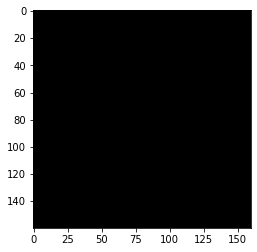

In [43]:
plt.imshow(imgs[2])

In [10]:

mpp_data = MPPData.from_data_dir('184A1_unperturbed/I09', base_dir=os.path.join(campa_config.EXPERIMENT_DIR, 'VAE_all/CondVAE_pert-CC/aggregated/full_data'), 
                                                    keys=['x', 'y', 'obj_ids', 'clustering_res0.5'], optional_keys=[])

INFO:MPPData:Setting mpp to empty array
INFO:MPPData:Created new: MPPData for NascentRNA (12132995 mpps with shape (1, 1, 35) from 886 objects). Data keys: ['x', 'y', 'obj_ids', 'mpp'].
INFO:MPPData:Loaded data from 184A1_unperturbed/I09.
INFO:MPPData:Setting mpp to empty array
INFO:MPPData:Created new: MPPData for NascentRNA (7218204 mpps with shape (1, 1, 34) from 557 objects). Data keys: ['obj_ids', 'clustering_res0.5', 'y', 'x', 'mpp'].
INFO:MPPData:Before subsetting: 886 objects
INFO:MPPData:Subsetting to 557 objects
INFO:MPPData:Updated data to keys ['x', 'y', 'obj_ids', 'mpp', 'clustering_res0.5']
INFO:MPPData:Loaded data from 184A1_unperturbed/I09, with base data from 184A1_unperturbed/I09


In [ ]:
example_cells[name] = sub_mpp_data.get_object_imgs(data=cluster_name, annotation_kwargs={'color':True, 'annotation': cl.cluster_annotation, 'to_col': 'annotation'}, img_size=160)


In [2]:
# example data
example_mpp_data = {'CondVAE':{}, 'MPPleiden': {}}

for name, data_dir in data_dirs.items():
    print(data_dir)
    example_mpp_data['CondVAE'][naame] = MPPData.from_data_dir(data_dir, base_dir=os.path.join(campa_config.EXPERIMENT_DIR, 'VAE_all/CondVAE_pert-CC/aggregated/full_data'), 
                                                    keys=['x', 'y', 'obj_ids', 'latent'], optional_keys=[])

for name, data_dir in data_dirs.items():
    print(data_dir)
    example_mpp_data['MPPleiden'][name] = MPPData.from_data_dir(data_dir, base_dir=os.path.join(campa_config.EXPERIMENT_DIR, 'VAE_all/MPPleiden/aggregated/full_data'), 
                                                    keys=['x', 'y', 'obj_ids', 'mpp'], optional_keys=[])

NameError: name 'data_dirs' is not defined